# Assignment Set 6
by **Amir Mehrpanah** for Deep Learing Course at Data Science Center, SBU

In [ ]:
#@title Data Injection
#@markdown here we also do the train test split
test_size = 0.35 #@param {type:"slider", min:0.10, max:0.35, step:0.01}
x = pd.read_csv('data/housing.csv').dropna()
y = x.pop('median_house_value')
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=test_size)

##Cleaning Data

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


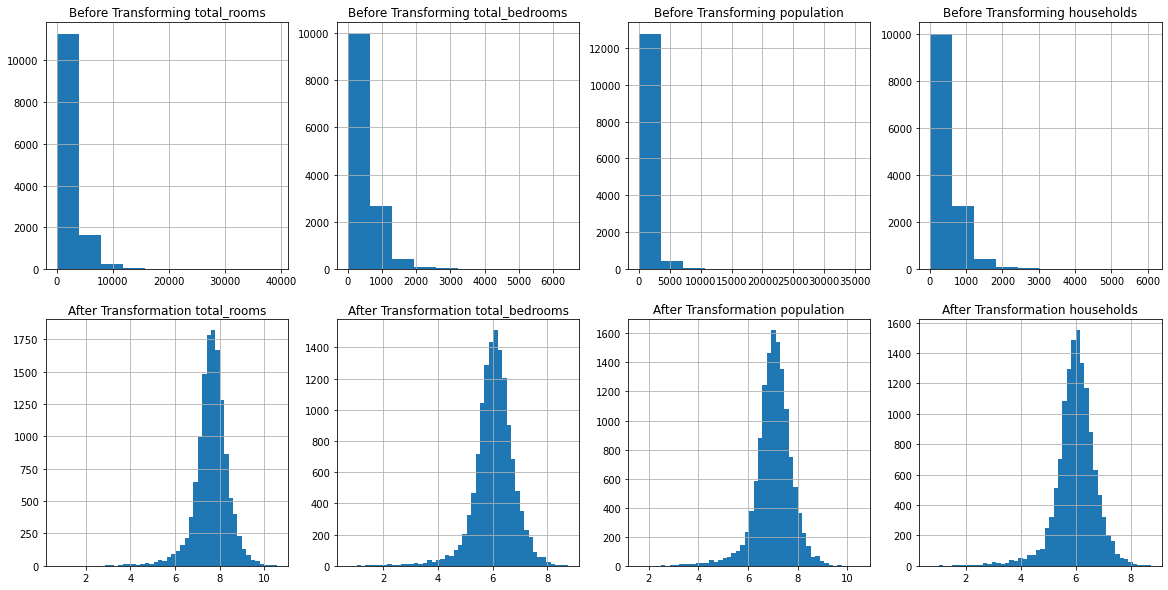

In [ ]:
#@title total_rooms + total_bedrooms + population
plt.figure(figsize=(20,10))
for i,idx in enumerate(['total_rooms',
                        'total_bedrooms',
                        'population',
                        'households']):
    ax = plt.subplot(2,4,i+1)
    ax.set_title('Before Transforming '+idx)
    x_train.loc[:,idx].hist()

    ax = plt.subplot(2,4,i+5)
    ax.set_title('After Transformation '+idx)
    x_train.loc[:,idx] = np.log(x_train.loc[:,idx])
    x_test.loc[:,idx] = np.log(x_test.loc[:,idx]) # in the transformation pipeline
    x_train.loc[:,idx].hist(bins=50)
plt.show()

In [ ]:
#@title ocean_proximity ordinal encoding
mapping = {'<1H OCEAN': 5, 
           'INLAND': 4,
           'ISLAND': 1,
           'NEAR BAY': 2,
           'NEAR OCEAN': 3}
x_train['ocean_proximity'] = x_train['ocean_proximity'].astype('category').map(mapping).astype('float')
x_test['ocean_proximity'] = x_test['ocean_proximity'].astype('category').map(mapping).astype('float') # in the transformation pipeline

In [ ]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test) # in the transformation pipeline
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size=0.1)

##  Building The Keras Models

In [ ]:
inputs = layers.Input(shape=(9))
l_ = layers.Dense(16,activation='relu')(inputs)
l_ = layers.Dense(8,activation='relu')(l_)
output = layers.Dense(1)(l_)

nonregularized_model = Model(inputs=inputs, outputs=output)
nonregularized_model.compile(optimizer="Adam", loss="mse")

inputs = layers.Input(shape=(9))
l_ = layers.Dense(16,activation='relu',kernel_regularizer=regularizers.l2(5e-1))(inputs)
l_ = layers.Dense(8,activation='relu',kernel_regularizer=regularizers.l2(5e-1))(l_)
l_ = layers.Dropout(.3)(l_)
output = layers.Dense(1)(l_)

l2regularized_model = Model(inputs=inputs, outputs=output)
l2regularized_model.compile(optimizer="Adam", loss="mse")

In [ ]:
epochs = 35 #@param {type:"integer"}
nonregularized_model.fit(x_train, y_train, batch_size= 32,
          epochs=epochs,
          validation_data=(x_val,y_val),
          validation_batch_size=32,
          use_multiprocessing=True,
          workers=-1,
          verbose=0)

l2regularized_model.fit(x_train, y_train, batch_size= 32,
          epochs=epochs,
          validation_data=(x_val,y_val),
          validation_batch_size=32,
          use_multiprocessing=True,
          workers=-1,
          verbose=0)

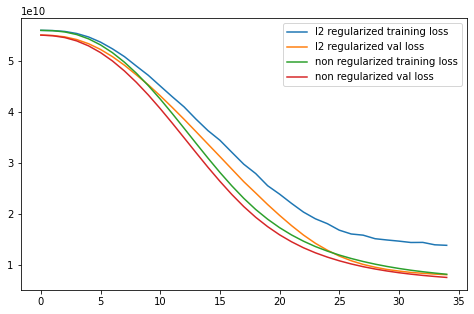

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(l2regularized_model.history.history['loss'],label = 'l2 regularized training loss')
plt.plot(l2regularized_model.history.history['val_loss'],label = 'l2 regularized val loss')
plt.plot(nonregularized_model.history.history['loss'],label = 'non regularized training loss')
plt.plot(nonregularized_model.history.history['val_loss'],label = 'non regularized val loss')
plt.legend()

In [ ]:
#@title Evaluation of The L1 Regularized Model and Non Regularized Model
print(nonregularized_model.evaluate(x_test, y_test))
print(l2regularized_model.evaluate(x_test, y_test))

202/202 [==============================] - 0s 1ms/step - loss: 8148801536.0000
8148801536.0
202/202 [==============================] - 0s 1ms/step - loss: 8677718016.0000
8677718016.0


In [ ]:
#@title Performance of The Old Model
model.evaluate(x_test, y_test)

202/202 [==============================] - 0s 1ms/step - loss: 4038575360.0000


4038575360.0

## Second Keras Model

In [ ]:
stride = 4

inputs = layers.Input(shape=(9))
l_ = layers.Dense(16,activation='linear')(inputs)

for i in range(16):
    l_ = layers.Dense(16,activation='linear')(l_)
    l_ = layers.Reshape((-1,1))(l_)
    l_ = layers.MaxPooling1D(pool_size=stride,strides=stride)(l_)
    l_ = layers.Flatten()(l_)
    
l_ = layers.Dense(8,activation='linear')(l_)
output = layers.Dense(1)(l_)

nonregularized_model = Model(inputs=inputs, outputs=output)
nonregularized_model.compile(optimizer="Adam", loss="mse")

# l2 regularized with dropout
inputs = layers.Input(shape=(9))
l_ = layers.Dense(16,activation='linear')(inputs)

for i in range(16):
    l_ = layers.Dense(16,activation='linear',kernel_regularizer=regularizers.l2(5e-1))(l_)
    l_ = layers.Reshape((-1,1))(l_)
    l_ = layers.MaxPooling1D(pool_size=stride,strides=stride)(l_)
    l_ = layers.Flatten()(l_)
    
l_ = layers.Dense(8,activation='linear',kernel_regularizer=regularizers.l2(5e-1))(l_)
l_ = layers.Dropout(.3)(l_)
output = layers.Dense(1)(l_)

l2regularized_model = Model(inputs=inputs, outputs=output)
l2regularized_model.compile(optimizer="Adam", loss="mse")

In [ ]:
epochs =  10#@param {type:"integer"}
nonregularized_model.fit(x_train, y_train, batch_size= 32,
          epochs=epochs,
          validation_data=(x_val,y_val),
          validation_batch_size=32,
          use_multiprocessing=True,
          workers=-1,
          verbose=0)

l2regularized_model.fit(x_train, y_train, batch_size= 32,
          epochs=epochs,
          validation_data=(x_val,y_val),
          validation_batch_size=32,
          use_multiprocessing=True,
          workers=-1,
          verbose=0)

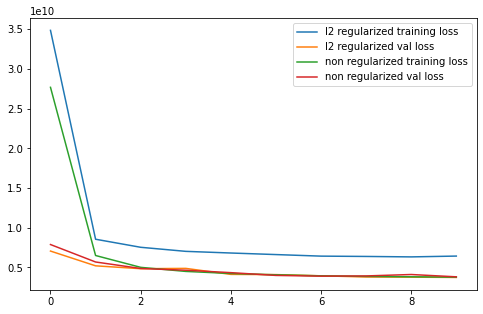

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(l2regularized_model.history.history['loss'],label = 'l2 regularized training loss')
plt.plot(l2regularized_model.history.history['val_loss'],label = 'l2 regularized val loss')
plt.plot(nonregularized_model.history.history['loss'],label = 'non regularized training loss')
plt.plot(nonregularized_model.history.history['val_loss'],label = 'non regularized val loss')
plt.legend()

In [ ]:
#@title Evaluation of The L1 Regularized Model and Non Regularized Model
print(nonregularized_model.evaluate(x_test, y_test))
print(l2regularized_model.evaluate(x_test, y_test))

202/202 [==============================] - 0s 2ms/step - loss: 3815310848.0000
3815310848.0
202/202 [==============================] - 0s 2ms/step - loss: 3721117952.0000
3721117952.0


In [ ]:
#@title Performance of The Old Model
model.evaluate(x_test, y_test)

202/202 [==============================] - 1s 4ms/step - loss: 3026082816.0000


3026082816.0